# Using Epidemic Size with Waning

In [11]:
from utils import seir_ivp, plot_scenarios_size

In [7]:
import numpy as np
from scipy.integrate import solve_ivp
import pandas as pd

In [8]:
def modified_seir_ivp_waning(t, y, beta, sigma, gamma, epsL, w):
    """
    Modified SEIR model for instantaneous vaccination. 
    """
    s, vs, vr, e, i, r = y
    
    dsdt = - beta*s*i
    dvsdt = - beta*vs*i + w*vr
    dvrdt = - beta*(1-epsL)*vr*i - w*vr
    dedt = beta*(s+vs+(1-epsL)*vr)*i - sigma*e
    didt = sigma*e - gamma*i
    drdt = gamma*i

    return [dsdt, dvsdt, dvrdt, dedt, didt, drdt]

In [9]:
def run_modified_seir_ivp_waning(y0: list, t: float, tv: float, beta: float, sigma: float, gamma: float, fv: float, \
    eps: float, w: float, mode: str = 'leaky'):
    s0, e0, i0, r0 = y0
    if mode == 'leaky':
        epsL = eps; epsA = 1
    elif mode == 'aon':
        epsL = 1; epsA = eps
    else:
        print("Mode must be 'leaky' or 'aon'.")
    
    if tv == -1:
        vs0 = fv*(1-epsA)*s0; vr0 = fv*epsA*s0; s0_vax = s0*(1-fv)
        y0_vax = [s0_vax, vs0, vr0, e0, i0, r0]
        sol_vax = solve_ivp(modified_seir_ivp_waning, [0, t], y0_vax, args=(beta, sigma, gamma, epsL, w), \
            dense_output=True)
        s_vax = sol_vax.y[0]; vs = sol_vax.y[1]; vr = sol_vax.y[2]; e_vax = sol_vax.y[3]
        i_vax = sol_vax.y[4]; r_vax = sol_vax.y[5]
        v = vs + vr

        return s_vax, vs, vr, v, e_vax, i_vax, r_vax
    
    else:
        sol = solve_ivp(seir_ivp, [0, tv], y0, args=(beta, sigma, gamma), dense_output=True)
        s = sol.y[0]; e = sol.y[1]; i = sol.y[2]; r = sol.y[3]

        vs0 = (1-epsA)*fv*s[-1]; vr0 = epsA*fv*s[-1]; s0_vax = s[-1]*(1-fv)
        y0_vax = [s0_vax, vs0, vr0, e[-1], i[-1], r[-1]]
        sol_vax = solve_ivp(modified_seir_ivp_waning, [tv, t], y0_vax, args=(beta, sigma, gamma, epsL, w), \
            dense_output=True)
        s_vax = sol_vax.y[0]; vs = sol_vax.y[1]; vr = sol_vax.y[2]; e_vax = sol_vax.y[3]
        i_vax = sol_vax.y[4]; r_vax = sol_vax.y[5]
        v = vs + vr

        s_vax = np.concatenate((s[:-1], s_vax), axis=None)
        vs = np.concatenate((np.zeros(np.shape(s[:-1])), vs), axis=None)
        vr = np.concatenate((np.zeros(np.shape(s[:-1])), vr), axis=None)
        v = np.concatenate((np.zeros(np.shape(s[:-1])), v), axis=None)
        e_vax = np.concatenate((e[:-1], e_vax), axis=None)
        i_vax = np.concatenate((i[:-1], i_vax), axis=None)
        r_vax = np.concatenate((r[:-1], r_vax), axis=None)
    
        return s_vax, vs, vr, v, e_vax, i_vax, r_vax

In [16]:
def run_scenarios_size_waning(y0: list, t: int, size: float, R0s: np.ndarray, sigma: float, gamma: float, w: float, \
    epss: np.ndarray, measured: int):  
    s0, e0, i0, r0 = y0
    df_R0s = []; df_epss = []; df_fvs = []
    covs = ['Below fc', 'Slightly Above fc', 'Above fc']; df_covs = []
    df_r_perc_leakys = []; df_r_perc_aons = []; df_r_perc_diffs = []
    df_rs = []; df_rleakys = []; df_raons = []

    for R0 in R0s:
        beta = R0 * gamma
        sol = solve_ivp(seir_ivp, [0, t], y0, args=(beta, sigma, gamma), dense_output=True)
        #r = sol.y[3]; r10 = r[-1]*0.1; r25 = r[-1]*0.25

        def _reach_size10(t, y, beta, sigma, gamma): return y[3] - 0.1
        def _reach_size25(t, y, beta, sigma, gamma): return y[3] - 0.25

        _reach_size10.terminate=True
        _reach_size25.terminate=True
                
        for eps in epss:
            if size == 0:
                fc = 1/eps * (1 - 1/R0)
                tv = -1
                t_new = measured
            else:
                if size == 0.1:
                    sol = solve_ivp(seir_ivp, [0, t], y0, args=(beta, sigma, gamma), \
                        events=_reach_size10, dense_output=True)
                elif size == 0.25:
                    sol = solve_ivp(seir_ivp, [0, t], y0, args=(beta, sigma, gamma), \
                        events=_reach_size25, dense_output=True)

                if np.array(sol.t_events).size == 0:
                    fc = 99999; fv = 99999; r_perc_leaky = 99999; r_perc_aon = 99999; r_perc_diff = 99999
                else:
                    s_temp = np.ravel(np.array(sol.y_events[0]))[0]
                    tv = np.ravel(np.array(sol.t_events))[0]
                    fc = 1/eps * (1 - 1/(R0*s_temp))
                    t_new = tv + measured
                        
            for cov in covs:
                if fc != 99999:
                    if cov == 'Below fc':
                        fv = fc * 0.8
                    elif cov == 'Slightly Above fc':
                        fv = 1 - ((1 - fc) * 0.8)
                    else:
                        fv = 1 - ((1 - fc) * 0.5)

                    if fv < 0:
                        fv = 0
                    elif fv > 0.98:
                        fv = 0.98
                    else:
                        fv = fv
                        
                    sol_vax = solve_ivp(seir_ivp, [0, t_new], y0, args=(beta, sigma, gamma), dense_output=True)
                    r_vax = sol_vax.y[3]
                        
                    _, _, _, _, _, _, r_leaky = run_modified_seir_ivp_waning(y0, t_new, tv, beta, sigma, gamma, fv, eps, w, mode='leaky')
                    _, _, _, _, _, _, r_aon = run_modified_seir_ivp_waning(y0, t_new, tv, beta, sigma, gamma, fv, eps, w, mode='aon')

                    r_perc_leaky = (r_vax[-1] - r_leaky[-1]) / r_vax[-1] * 100
                    r_perc_aon = (r_vax[-1] - r_aon[-1]) / r_vax[-1] * 100
                    r_perc_diff = abs(r_perc_aon - r_perc_leaky)

                df_R0s.append(R0)
                df_epss.append(eps)
                df_fvs.append(fv)
                df_covs.append(cov)
                df_r_perc_leakys.append(r_perc_leaky)
                df_r_perc_aons.append(r_perc_aon)
                df_r_perc_diffs.append(r_perc_diff)

    # build dataframe                        
    data = {'R0': df_R0s, 'VE': df_epss, 'Vax Coverage': df_covs, 'fv': df_fvs, \
        'Leaky': df_r_perc_leakys, 'AON': df_r_perc_aons, 'Diff': df_r_perc_diffs}
    vax_df = pd.DataFrame(data=data)

    return vax_df

## Measured 30 Days After Vaccination

/Users/dianelee/Documents/Github/vaccine-efficacy/VaccineEfficacy/utils/utils.py:707: UserWarning: FixedFormatter should only be used together with FixedLocator
  cb.ax.set_yticklabels(np.round(np.exp(cblabels)-1).astype(int))


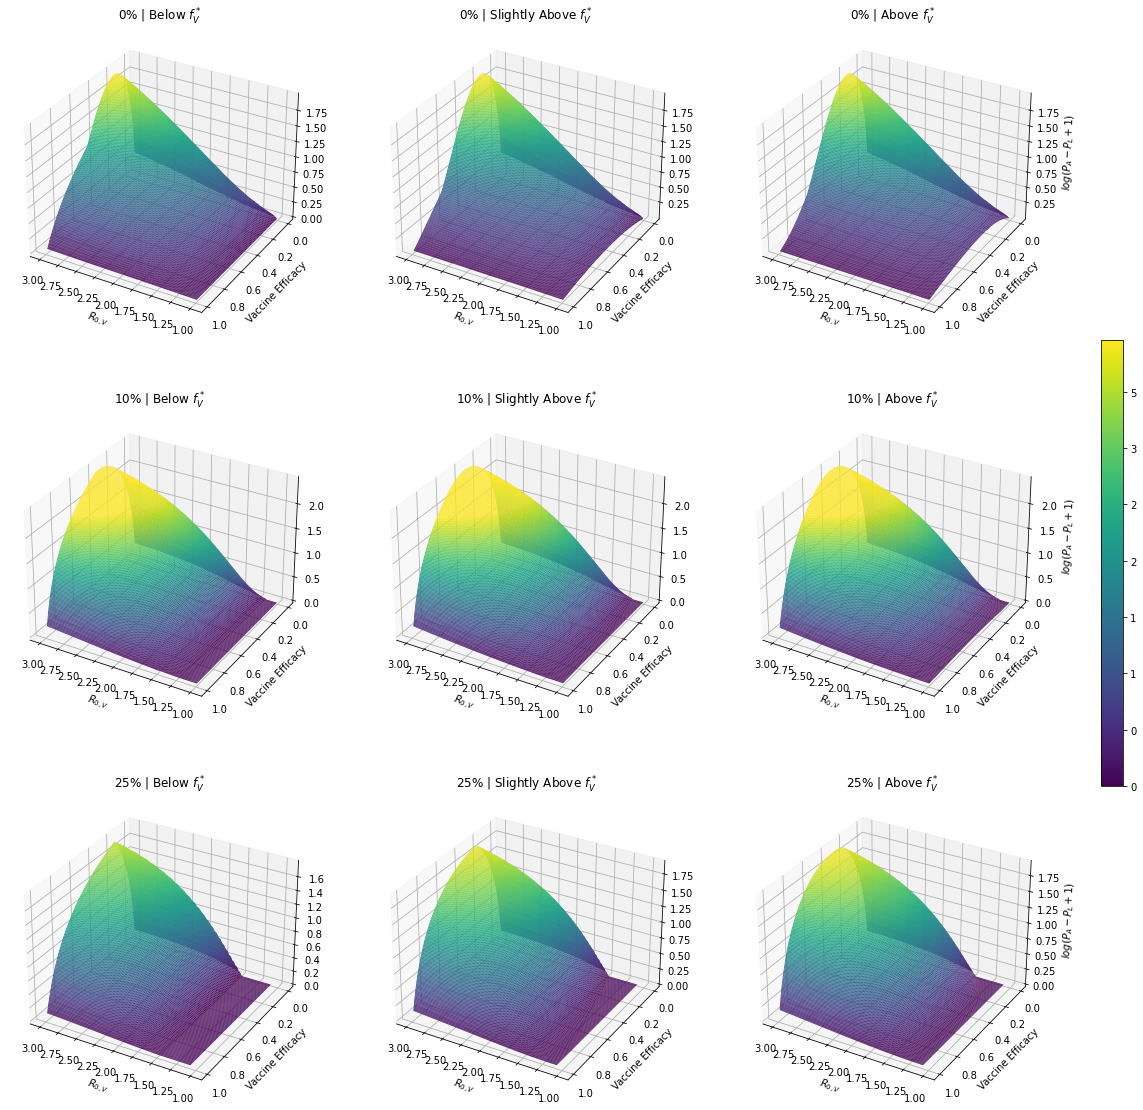

In [12]:
sigma = 1/4; gamma = 1/4; t = 300; w = 0.0075
s0 = 0.98; e0 = 0.01; i0 = 0.01; r0 = 0; y0 = [s0, e0, i0, r0]
r0s = np.arange(1.0, 3.0, 0.01); epss = np.arange(0.01, 1.0, 0.01)

epi0_df_30 = run_scenarios_size_waning(y0, t, 0, r0s, sigma, gamma, w, epss, measured=30)
epi10_df_30 = run_scenarios_size_waning(y0, t, 0.1, r0s, sigma, gamma, w, epss, measured=30)
epi25_df_30 = run_scenarios_size_waning(y0, t, 0.25, r0s, sigma, gamma, w, epss, measured=30)

fig_3d = plot_scenarios_size(epi0_df_30, epi10_df_30, epi25_df_30, dim=3)
#plt.savefig('epidemicsize_3d.jpg', bbox_inches='tight')
fig_2d = plot_scenarios_size(epi0_df_30, epi10_df_30, epi25_df_30, dim=2)
#plt.savefig('epidemicsize_2d.jpg', bbox_inches='tight')

## Measured 60 Days After Vaccination

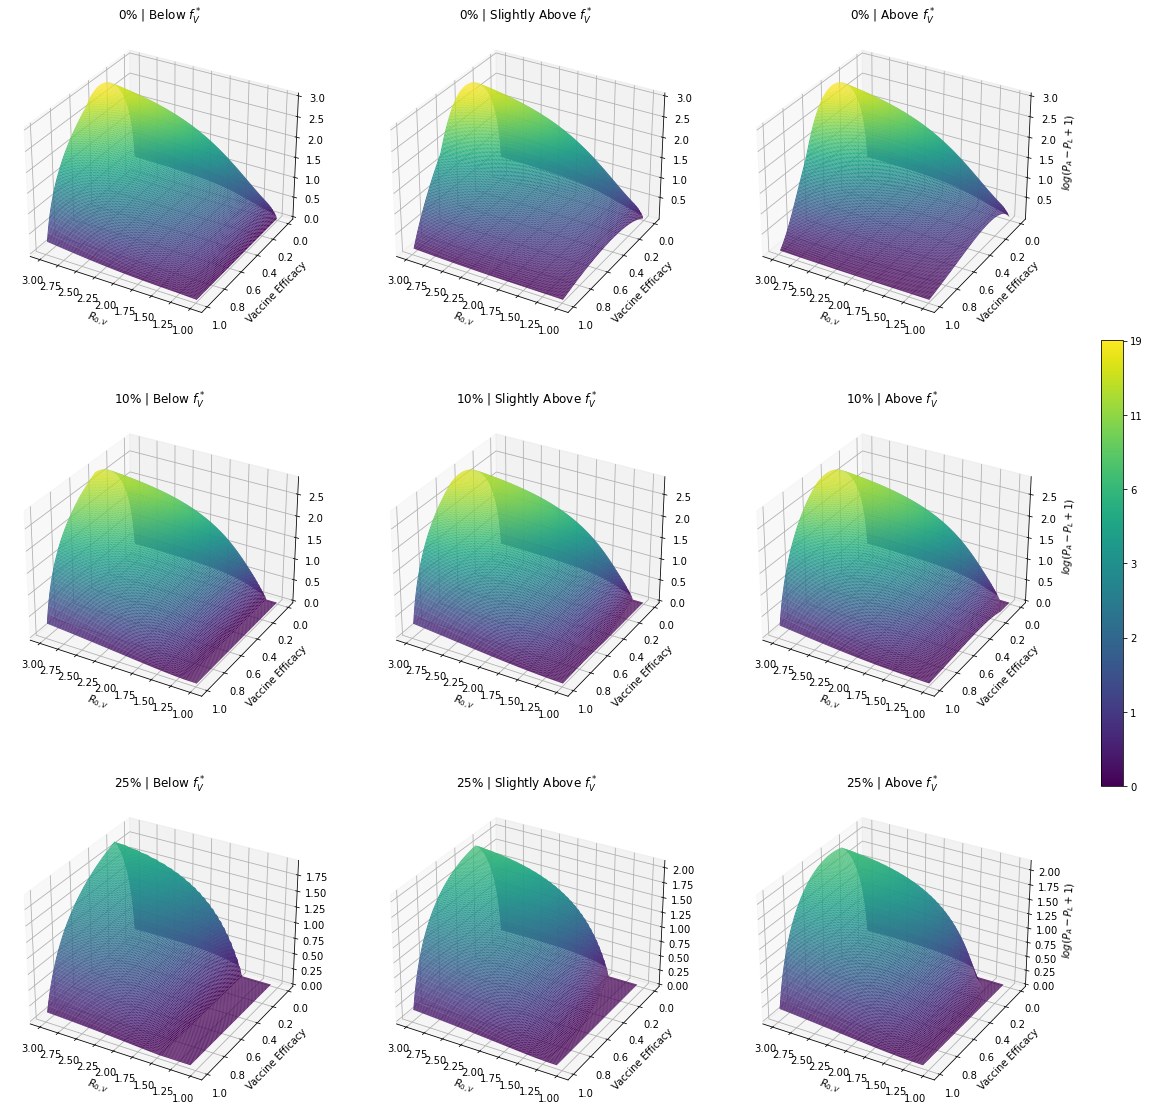

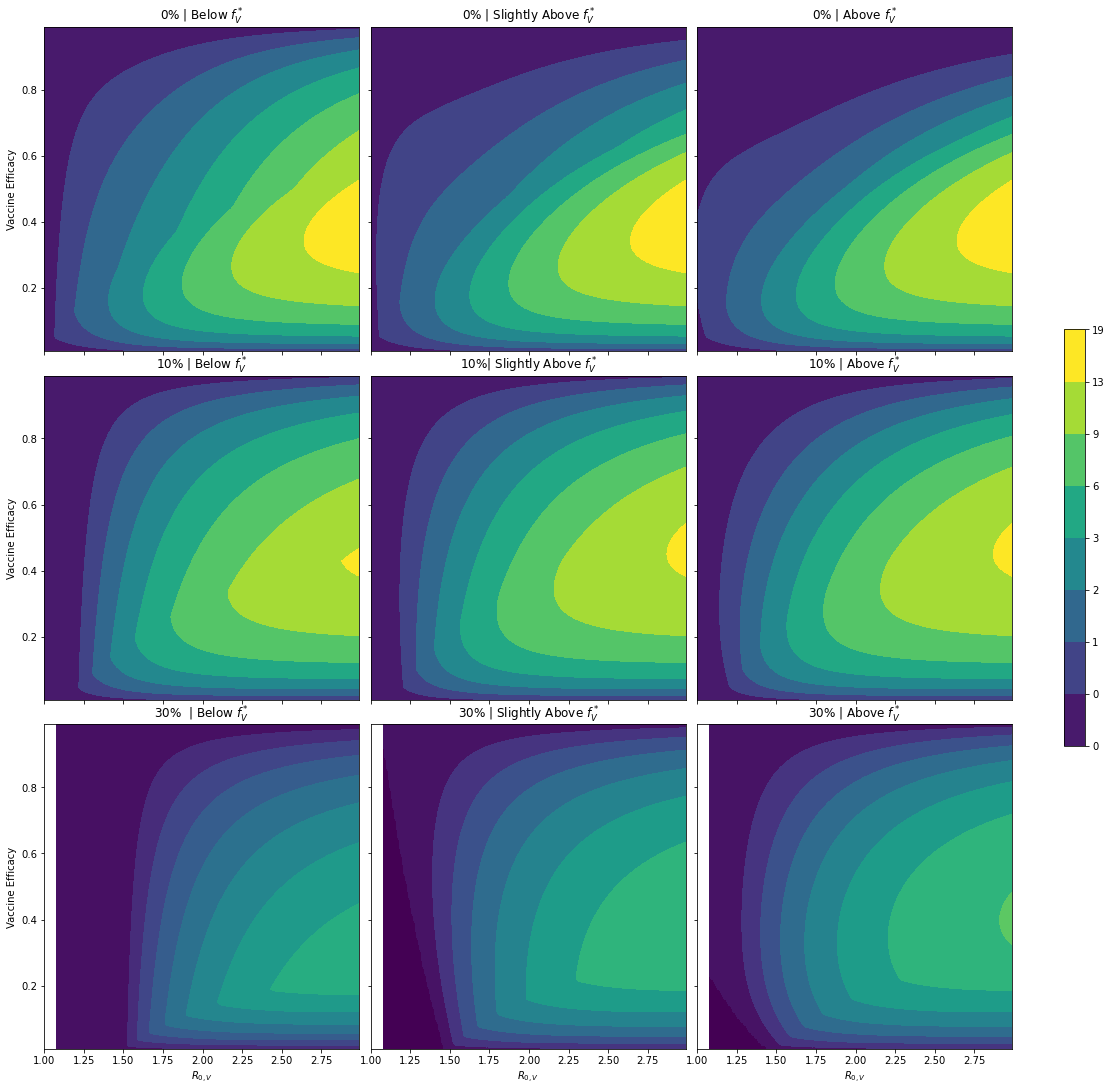

In [13]:
sigma = 1/4; gamma = 1/4; t = 300; w = 0.0075
s0 = 0.98; e0 = 0.01; i0 = 0.01; r0 = 0; y0 = [s0, e0, i0, r0]
r0s = np.arange(1.0, 3.0, 0.01); epss = np.arange(0.01, 1.0, 0.01)

epi0_df_60 = run_scenarios_size_waning(y0, t, 0, r0s, sigma, gamma, w, epss, measured=60)
epi10_df_60 = run_scenarios_size_waning(y0, t, 0.1, r0s, sigma, gamma, w, epss, measured=60)
epi25_df_60 = run_scenarios_size_waning(y0, t, 0.25, r0s, sigma, gamma, w, epss, measured=60)

fig_3d = plot_scenarios_size(epi0_df_60, epi10_df_60, epi25_df_60, dim=3)
#plt.savefig('epidemicsize_3d.jpg', bbox_inches='tight')
fig_2d = plot_scenarios_size(epi0_df_60, epi10_df_60, epi25_df_60, dim=2)
#plt.savefig('epidemicsize_2d.jpg', bbox_inches='tight')

## Measured 100 Days After Vaccination

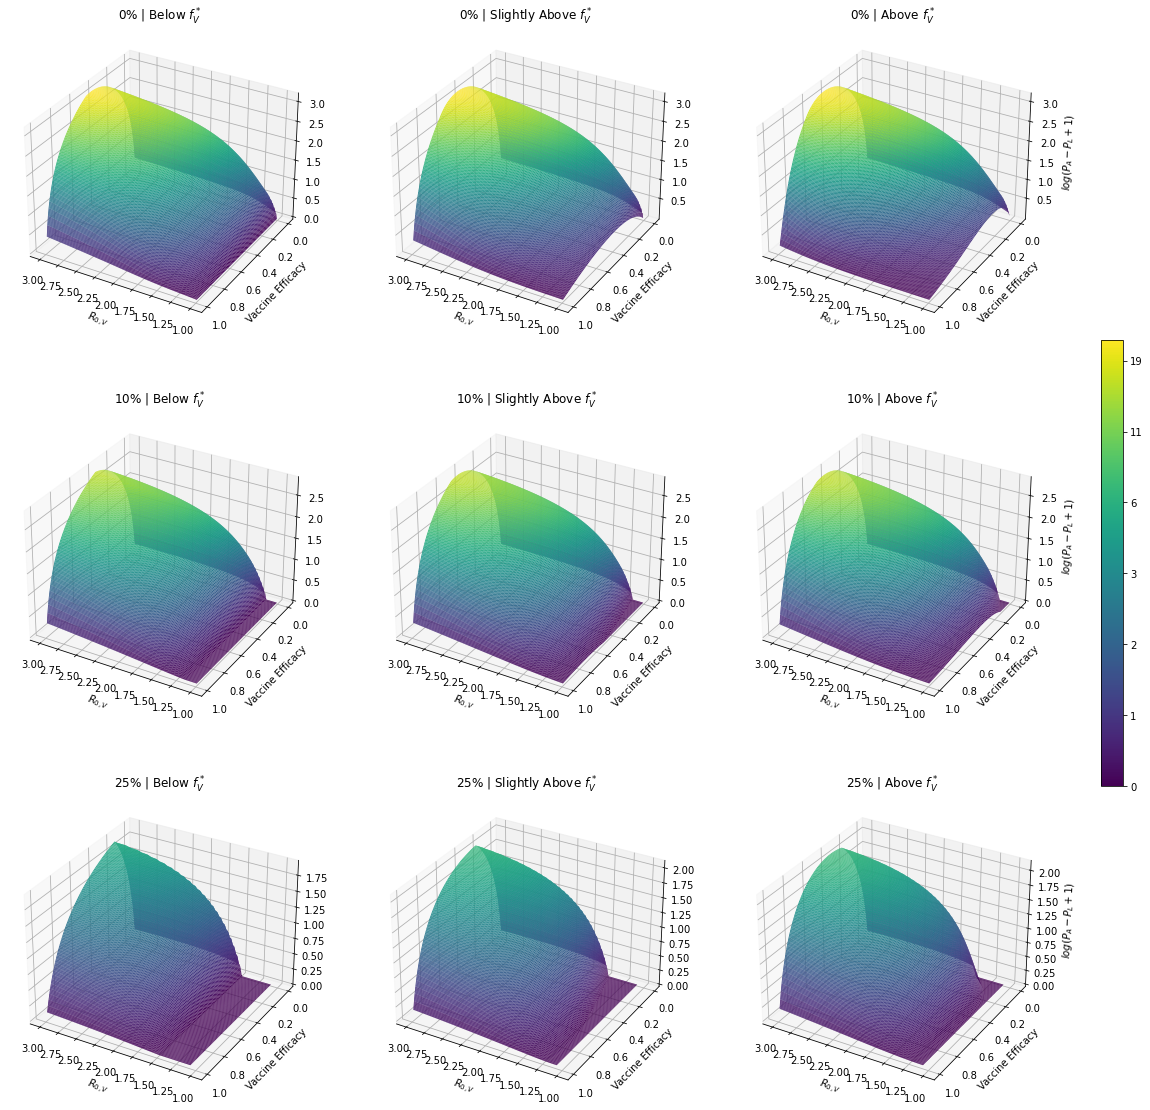

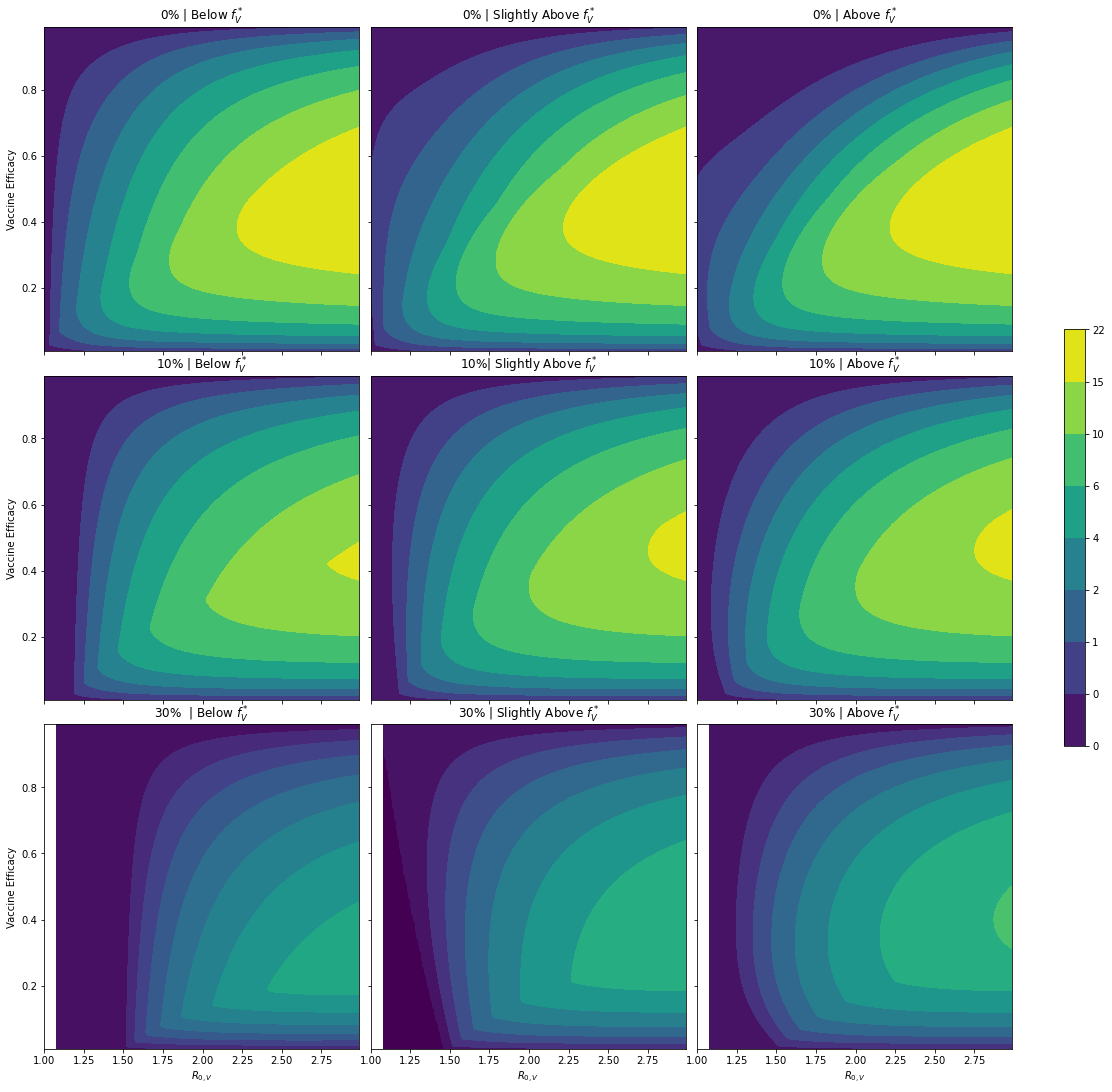

In [14]:
sigma = 1/4; gamma = 1/4; t = 300; w = 0.0075
s0 = 0.98; e0 = 0.01; i0 = 0.01; r0 = 0; y0 = [s0, e0, i0, r0]
r0s = np.arange(1.0, 3.0, 0.01); epss = np.arange(0.01, 1.0, 0.01)

epi0_df_100 = run_scenarios_size_waning(y0, t, 0, r0s, sigma, gamma, w, epss, measured=100)
epi10_df_100 = run_scenarios_size_waning(y0, t, 0.1, r0s, sigma, gamma, w, epss, measured=100)
epi25_df_100 = run_scenarios_size_waning(y0, t, 0.25, r0s, sigma, gamma, w, epss, measured=100)

fig_3d = plot_scenarios_size(epi0_df_100, epi10_df_100, epi25_df_100, dim=3)
#plt.savefig('epidemicsize_3d.jpg', bbox_inches='tight')
fig_2d = plot_scenarios_size(epi0_df_100, epi10_df_100, epi25_df_100, dim=2)
#plt.savefig('epidemicsize_2d.jpg', bbox_inches='tight')

## Measured 300 Days After Vaccination

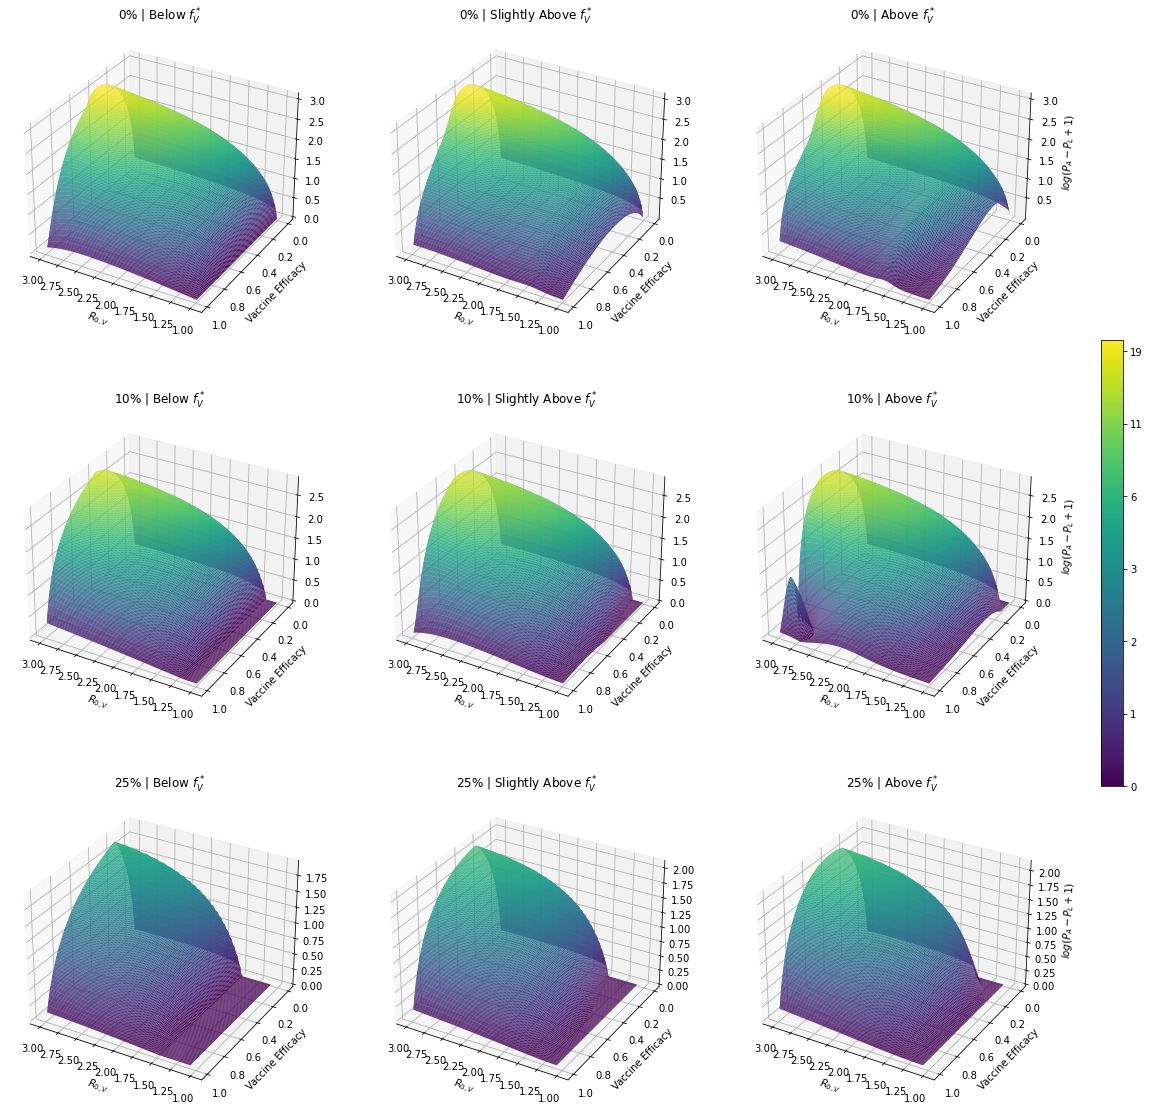

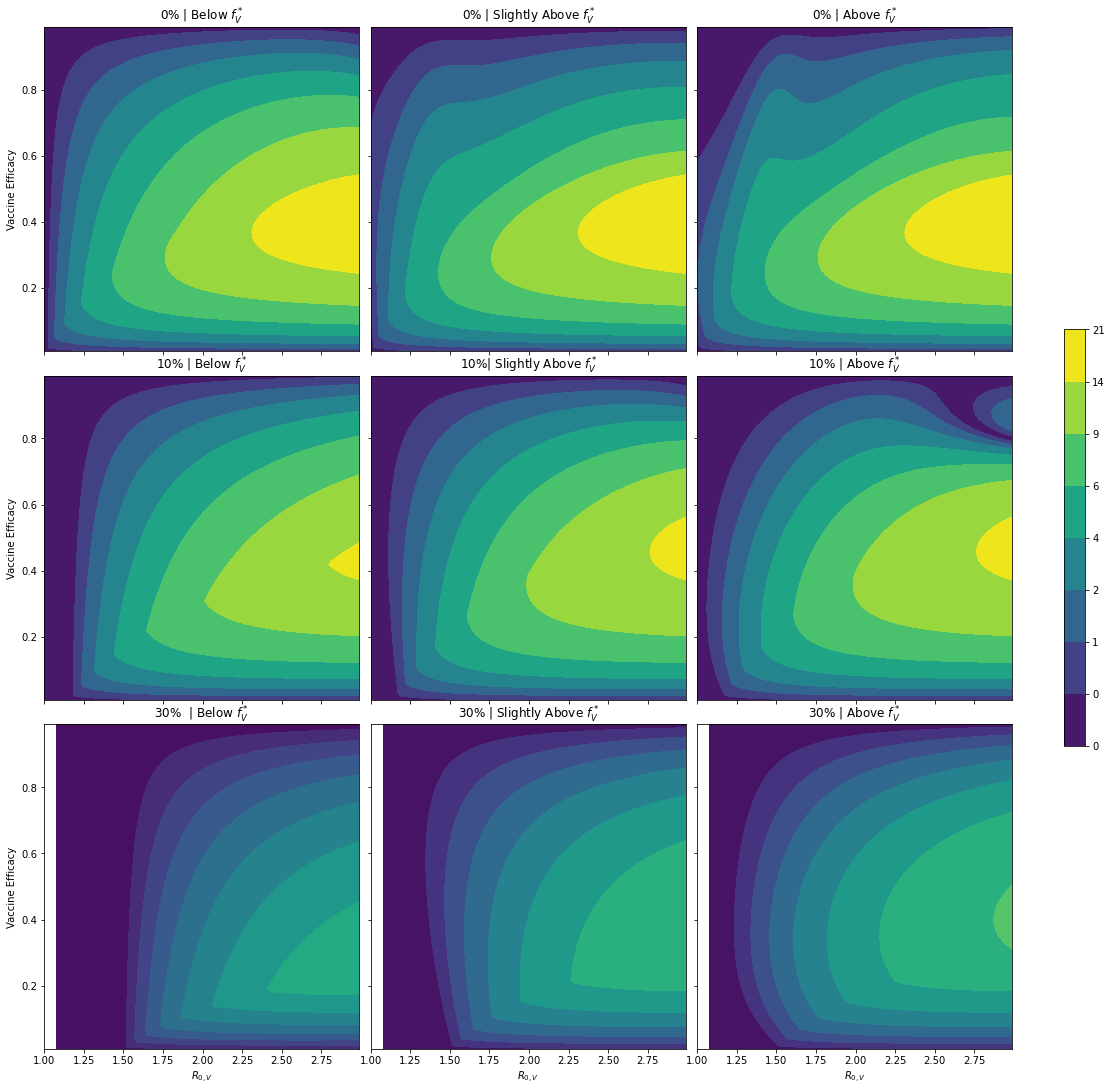

In [17]:
sigma = 1/4; gamma = 1/4; t = 300; w = 0.0075
s0 = 0.98; e0 = 0.01; i0 = 0.01; r0 = 0; y0 = [s0, e0, i0, r0]
r0s = np.arange(1.0, 3.0, 0.01); epss = np.arange(0.01, 1.0, 0.01)

epi0_df_300 = run_scenarios_size_waning(y0, t, 0, r0s, sigma, gamma, w, epss, measured=300)
epi10_df_300 = run_scenarios_size_waning(y0, t, 0.1, r0s, sigma, gamma, w, epss, measured=300)
epi25_df_300 = run_scenarios_size_waning(y0, t, 0.25, r0s, sigma, gamma, w, epss, measured=300)

fig_3d = plot_scenarios_size(epi0_df_300, epi10_df_300, epi25_df_300, dim=3)
#plt.savefig('epidemicsize_3d.jpg', bbox_inches='tight')
fig_2d = plot_scenarios_size(epi0_df_300, epi10_df_300, epi25_df_300, dim=2)
#plt.savefig('epidemicsize_2d.jpg', bbox_inches='tight')